# Classification

## Setup

In [63]:
import sklearn
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# to plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc("axes", labelsize = 14)
mpl.rc("xtick", labelsize = 12)
mpl.rc("ytick", labelsize = 12)

## MNIST

We will be using the MNIST dataset, which is a set of 70,000 small
images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. This set has been studied so much that it is often called the “Hello World” of Machine Learning

Scikit-Learn provides many helper functions to download popular datasets. MNIST is
one of them. The following code fetches the MNIST dataset

In [64]:
from sklearn.datasets import fetch_openml


# Warning: since Scikit-Learn 0.24, fetch_openml() returns a Pandas DataFrame by default. To avoid this and keep the same code as in the book, we use as_frame=False

mnist = fetch_openml("mnist_784", version=1, as_frame=False)
mnist

c:\Users\DELL\anaconda3\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


{'data': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'target': array(['5', '0', '4', ..., '4', '5', '6'], dtype=object),
 'frame': None,
 'categories': {},
 'feature_names': ['pixel1',
  'pixel2',
  'pixel3',
  'pixel4',
  'pixel5',
  'pixel6',
  'pixel7',
  'pixel8',
  'pixel9',
  'pixel10',
  'pixel11',
  'pixel12',
  'pixel13',
  'pixel14',
  'pixel15',
  'pixel16',
  'pixel17',
  'pixel18',
  'pixel19',
  'pixel20',
  'pixel21',
  'pixel22',
  'pixel23',
  'pixel24',
  'pixel25',
  'pixel26',
  'pixel27',
  'pixel28',
  'pixel29',
  'pixel30',
  'pixel31',
  'pixel32',
  'pixel33',
  'pixel34',
  'pixel35',
  'pixel36',
  'pixel37',
  'pixel38',
  'pixel39',
  'pixel40',
  'pixel41',
  'pixel42',
  'pixel43',
  'pixel44',
  'pixel45',
  'pixel46',
  'pixel47',
  'pixel48',
  'pixe

Datasets loaded by Scikit-Learn generally have a similar dictionary structure including:

-  A `DESCR` key describing the dataset
- A `data` key containing an array with one row per instance and one column per feature
-  A `target` key containing an array with the labels

Let’s look at these arrays:

In [65]:
X, y = mnist["data"], mnist["target"]

In [66]:
X.shape

(70000, 784)

In [67]:
y.shape

(70000,)

There are 70,000 images, and each image has 784 features. This is because each image
is 28×28 pixels, and each feature simply represents one pixel’s intensity, from 0
(white) to 255 (black).

Let’s take a peek at one digit from the dataset. 

All you need to
do is grab an instance’s feature vector, reshape it to a 28×28 array, and display it using
Matplotlib’s imshow() function:

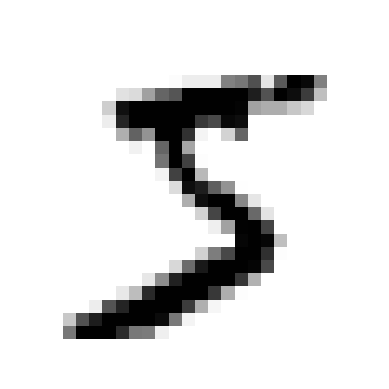

In [68]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

This looks like a 5, and indeed that’s what the label tells us:

In [69]:
y[0]

'5'

In [70]:
y = y.astype(np.uint8)

In [71]:
def plot_digit(data):
    image = data.reshape(28,8)
    plt.imshow(image, cmap=mpl.cm.binary, interpolation="nearest")
    plt.axis("off")

In [72]:
import math

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row )
    n_rows = math.ceil(len(instances) / images_per_row)
    
    # Append empty images to fill the end of the grid, if needed
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size*size))], axis=0)
    
    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))
    
    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

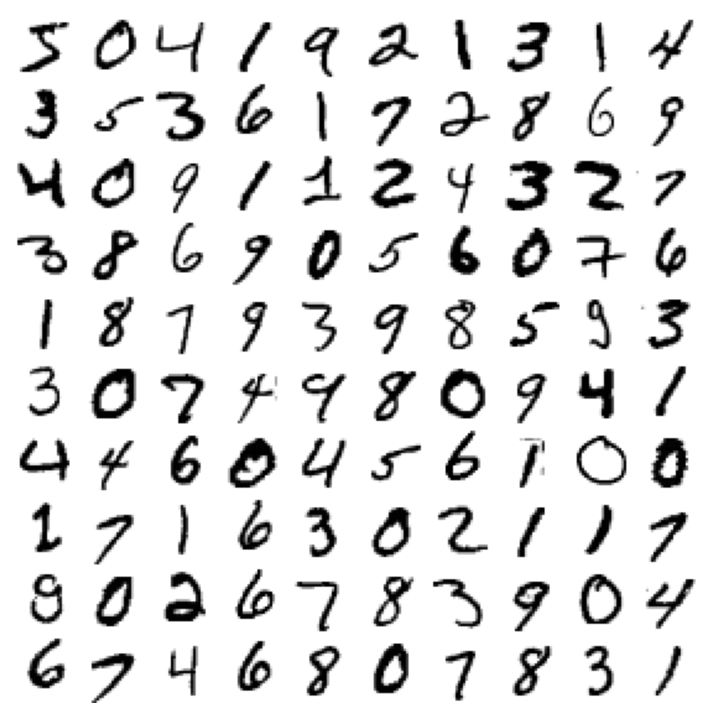

In [73]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

 The MNIST dataset is actually already split into a training set (the first 60,000
images) and a test set (the last 10,000 images)

In [74]:
X_train, X_test , y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Let’s also shuffle the training set; this will guarantee that all cross-validation folds will
be similar (you don’t want one fold to be missing some digits)

In [75]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a Binary Classifier

Let’s simplify the problem for now and only try to identify one digit—for example,
the number 5. This “5-detector” will be an example of a binary classifier, capable of
distinguishing between just two classes, 5 and not-5.

Let’s create the target vectors for
this classification task

In [76]:
y_train_5 = (y_train == 5) # True for all 5s, False for other digits
y_test_5 = (y_test == 5)

Okay, now let’s pick a classifier and train it. A good place to start is with a `Stochastic Gradient Descent` (SGD) classifier, using Scikit-Learn’s `SGDClassifier` class.

This classifier has the advantage of being capable of handling very large datasets efficiently.
This is in part because SGD deals with training instances independently, one at a time
(which also makes SGD well suited for online learning).

Let’s create
an `SGDClassifier` and train it on the whole training set

In [77]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Now you can use it to detect images of the number 5:

In [78]:
sgd_clf.predict([some_digit])

array([ True])

The classifier guesses that this image represents a 5 (True). Looks like it guessed right
in this particular case! Now, let’s evaluate this model’s performance.

## Performance Measures

Evaluating a classifier is often significantly trickier than evaluating a regressor, so we
will spend a large part of this chapter on this topic

### Measuring Accuracy using Cross-Validation

#### (Extra) Implementing Cross-Validation

Occasionally you will need more control over the cross-validation process than what
`cross_val_score()` and similar functions provide. In these cases, you can implement
cross-validation yourself. 

In [79]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Provides train/test indices to split data in train/test sets

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.96285
0.96195
0.9563


The `StratifiedKFold` class performs stratified sampling 
to produce folds that contain a representative ratio of each class. At each iteration the
code creates a clone of the classifier, trains that clone on the training folds, and makes
predictions on the test fold. Then it counts the number of correct predictions and
outputs the ratio of correct predictions.

Let’s use the `cross_val_score()` function to evaluate your `SGDClassifier` model
using K-fold cross-validation, with three folds. Remember that K-fold cross-validation means splitting the training set into K-folds (in this case, three), then making predictions and evaluating them on each fold using a model trained on the
remaining folds. 

In [80]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9681 , 0.95655, 0.95515])

Wow! Above 95% accuracy (ratio of correct predictions) on all cross-validation folds? 
This looks amazing, doesn’t it? Well, before you get too excited, let’s look at a very
dumb classifier that just classifies every single image in the “not-5” class

In [81]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

In [83]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90745, 0.9125 ])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the
images are 5s, so if you always guess that an image is not a 5, you will be right about
90% of the time

This demonstrates why accuracy is generally not the preferred performance measure
for classifiers, especially when you are dealing with *skewed datasets* (i.e., when some
classes are much more frequent than others)

### Confusion Matrix

Better way to evaluate performance of classifier. General idea is to count the number of times instances of class A are classified as class B.

For example: To check how many times our classifier confused images of 5s as 3s, is to look the matrix in 5th row 3rd column

To compute confusion matrix we need a set to predictions, so that they can be compared with the actual targets. One way is to make predictions on test case, but it is better not to use test case now (Remember use test case only when the model is finally ready). 

Instead we can use `cross_val_predict` function:

In [84]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like `cross_val_score` function, `cross-val_predict` performs K-fold cross-validation but instead of returning the score, it make predictions on each test fold. 

Now we are ready to make confusion matrix using `confusion_matrix()` function. Just pass target classes `y_train_5` and predicted classes `y_train_pred`

In [85]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53124,  1455],
       [  949,  4472]], dtype=int64)

Each row in confusion matrix represents an `actual class`, while each column represnets `predicted class`. 

Confusion Matrix = 
$\begin{bmatrix} \textbf{Class:} & \textbf{non-5} & \textbf{5}\\ \textbf{non-5} & 53124 & 1452\\ \textbf{5} & 949 & 4472\end{bmatrix}$

First row represents non-5 images (the negative class). 53124 of them were correctly classified as non-5s (called *true negatives*), while 1455 were wrongly classified as 5 (*false positive*).

Second row represents 5 images (the positive class). 949 of them were wrongly classified as non-5 (*false negatives*), whereas 4472 were correctly classified as 5 (*true positive*).

Confusion Matrix = 
$\begin{bmatrix}  & \textbf{Negative} & \textbf{Positive}\\ \textbf{Negative} & TN & FP\\ \textbf{Positive} & FN & TP\end{bmatrix}$

A perfect classifier would have only true positives and true negatives values, so its confusion matrix would have non zero values only in its diagonal (from top left to bottom right)

In [87]:
y_train_prefect_predictions = y_train_5 # pretend we reached perfection

confusion_matrix(y_train_5, y_train_prefect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

A confusion matrix gives you a lot of information, but sometimes you may prefer a concise metric.

An intresting to look at is the accuracy of positive predictions, this is called as `precision` of classifier.

$$Precision = \frac{TP}{FP+TP}$$
where $TP$ is the number of true positives and $FP$ is the number of false positives

`Precision` is typically used with another metric called `recall` also called `sensitivity` or `true positive rate (TPR)` : this is ratio of positive instances that are correctly detected by the classifier

$$ Recall = \frac{TP}{TP+FN} $$
wher $FN$ is number of false negatives

Illustration for understanding confusion matrix, precision and recall

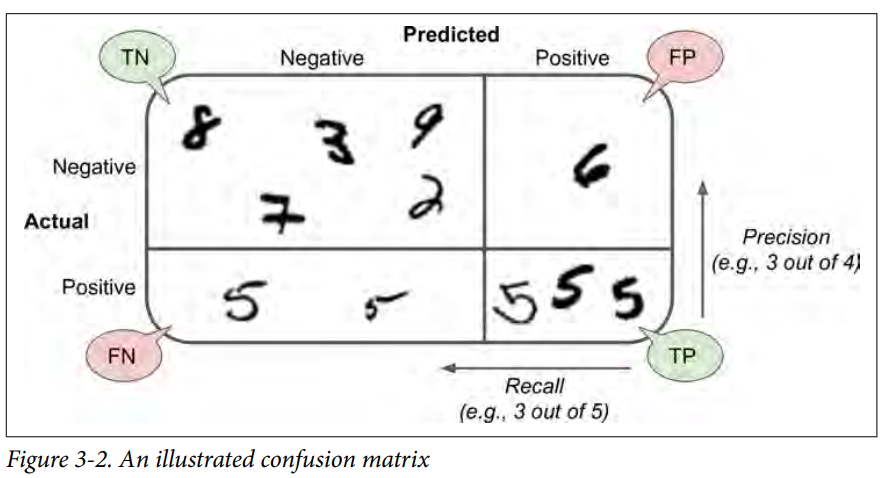